<a href="https://colab.research.google.com/github/gmauricio-toledo/NLP-LCC/blob/main/Notebooks/05-n_gramas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Modelos de lenguaje: $N$-gramas

Usaremos el corpus Reuters para entrenar un primer modelo de lenguaje. Este modelo lo usaremos para predicir la siguiente palabra en una secuencia de palabras dada.

El Corpus Reuters contiene 10,788 documentos de noticias con un total de 1.3 millones de palabras. Los documentos se han clasificado en 90 temas y agrupado en dos conjuntos, *train* y *test*.

* Corpus en NLTK: https://www.nltk.org/howto/corpus.html

In [2]:
!gdown 1kvdbFQF9G1LTmcTVEPPy57nJRTuT2Kkt

Downloading...
From (original): https://drive.google.com/uc?id=1kvdbFQF9G1LTmcTVEPPy57nJRTuT2Kkt
From (redirected): https://drive.google.com/uc?id=1kvdbFQF9G1LTmcTVEPPy57nJRTuT2Kkt&confirm=t&uuid=a6a23320-ab48-46da-933f-b35f66044cc3
To: /content/wikipedia_batch_001_cleantext.csv
100% 258M/258M [00:03<00:00, 85.1MB/s]


## Modelo de 3-gramas

Exploremos un poco el corpus.

In [3]:
import pandas as pd

df = pd.read_csv('wikipedia_batch_001_cleantext.csv')
df

,text,clean text
0,}} }} }} }} }} }} }} Wikipedia dispone varios...,Wikipedia dispone varios proyectos internos pa...
1,|latín: « virtud más fuerte unida») |catalán:...,latín « virtud más fuerte unida») catalán « Gr...
2,|15px|right|Escudo ciudad Buenos Aires |15p...,15px right Escudo ciudad Buenos Aires 15px rig...
3,"|país 1 = España |frontera país 1 = 63,7 |paí...","país 1 España frontera país 1 63,7 país 2 Fran..."
4,"|edad_0-14_años = 13,87% |edad_15-64_años = 72...","edad_0-14_años 13,87% edad_15-64_años 72,54% A..."
...,...,...
9995,Puntero tiene diferentes acepciones según con...,Puntero tiene diferentes acepciones según cont...
9996,} |más info = [ Ficha seguridad ICSC 0405] }}...,más info [ Ficha seguridad ICSC 0405] cafeína ...
9997,"ámbito química orgánica, las aminas son comp...","ámbito química orgánica, las aminas son compue..."
9998,Una las motivaciones detrás creación Solit...,Una las motivaciones detrás creación Solitaire...


In [4]:
import re
import unicodedata

def limpiar_texto(texto):
    """
    Limpia un texto removiendo dígitos, puntuaciones, caracteres especiales,
    letras griegas, 'px', y otros elementos no deseados.

    Args:
        texto (str): Texto a limpiar

    Returns:
        str: Texto limpio
    """

    # Convertir a minúsculas
    texto = texto.lower()

    # Remover entidades HTML como &nbsp;
    texto = re.sub(r'&[a-z]+;', ' ', texto)

    # Remover 'px' (pixeles)
    texto = re.sub(r'\d*\.?\d+\s*px', ' ', texto)
    texto = re.sub(r'px', ' ', texto)

    # Remover letras griegas (alfabeto griego completo)
    # Rango Unicode para letras griegas: U+0370 a U+03FF
    texto = ''.join(char if not ('\u0370' <= char <= '\u03FF') else ' ' for char in texto)

    # Remover números (enteros y decimales)
    texto = re.sub(r'\d+\.?\d*', ' ', texto)

    # Remover símbolos matemáticos y científicos comunes
    texto = re.sub(r'[°±×÷√∞≈≠≤≥]', ' ', texto)

    # Remover puntuación y caracteres especiales
    # Mantener solo letras, espacios y algunos caracteres básicos
    texto = re.sub(r'[^\w\sáéíóúñüàèìòùâêîôûäëïöü]', ' ', texto)

    # Remover guiones bajos
    texto = re.sub(r'_+', ' ', texto)

    # Remover caracteres de control y formato
    texto = ''.join(char for char in texto if unicodedata.category(char)[0] != 'C')

    # Normalizar espacios múltiples a uno solo
    texto = re.sub(r'\s+', ' ', texto)

    return texto

In [5]:
df['clean text'] = df['clean text'].apply(limpiar_texto)
df

,text,clean text
0,}} }} }} }} }} }} }} Wikipedia dispone varios...,wikipedia dispone varios proyectos internos pa...
1,|latín: « virtud más fuerte unida») |catalán:...,latín virtud más fuerte unida catalán gran car...
2,|15px|right|Escudo ciudad Buenos Aires |15p...,right escudo ciudad buenos aires right escudo...
3,"|país 1 = España |frontera país 1 = 63,7 |paí...",país españa frontera país país francia fronter...
4,"|edad_0-14_años = 13,87% |edad_15-64_años = 72...",edad años edad años andorrana caucásicos andor...
...,...,...
9995,Puntero tiene diferentes acepciones según con...,puntero tiene diferentes acepciones según cont...
9996,} |más info = [ Ficha seguridad ICSC 0405] }}...,más info ficha seguridad icsc cafeína antioxid...
9997,"ámbito química orgánica, las aminas son comp...",ámbito química orgánica las aminas son compues...
9998,Una las motivaciones detrás creación Solit...,una las motivaciones detrás creación solitaire...


In [6]:
for text in df['clean text'].sample(2):
    print(text)

 fue año común comenzado domingo del calendario juliano vigor aquella fecha junio emperador murakami japón gamle eriksson diciembre guillermo duque aquitania 
osmolaridad medida para expresar concentración total medida osmoles litro sustancias disoluciones usadas medicina prefijo osmo indica posible variación presión osmótica las células que producirá introducir disolución organismo osmolalidad véase que diferente osmolaridad concentración queda expresada como osmoles por kilogramo agua referentes también algunas sustancias específicas concentración osmótica normalmente conocida como osmolaridad medición concentración solutos definida como número osmoles osm soluto por litro solución osmol osm osmolaridad una solución esta usualmente expresada osm pronunciado osmolar misma manera que molaridad una solución está expresada como pronunciado molar mientras que molaridad mide número moles soluto por unidad volumen una solución osmolaridad mide número osmoles soluto participantes por unidad 

### Crear el modelo de lenguaje

In [7]:
import nltk
from nltk import bigrams, trigrams
nltk.download('punkt_tab')

def crear_modelo_trigrama(texto):
    """
    Crea un modelo de trigramas desde un texto.

    texto: String con el texto de entrenamiento

    Returns:
        Modelo (diccionario de probabilidades)
    """
    # Tokenizar
    palabras = nltk.word_tokenize(texto.lower(), language='spanish')

    # Crear trigramas
    trigramas = []
    for i in range(len(palabras) - 2):
        trigramas.append((palabras[i], palabras[i+1], palabras[i+2]))

    # Alternativamente, crear trigramas con nltk
    # trigramas = list(trigrams(palabras))

    # Contar
    conteos = {}
    for w1, w2, w3 in trigramas:
        if (w1, w2) not in conteos:
            conteos[(w1, w2)] = {}
        if w3 not in conteos[(w1, w2)]:
            conteos[(w1, w2)][w3] = 0
        conteos[(w1, w2)][w3] += 1

    # Convertir a probabilidades
    modelo = {}
    for par, terceras in conteos.items():
        total = sum(terceras.values())
        modelo[par] = {palabra: cuenta/total for palabra, cuenta in terceras.items()}

    return modelo

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Entrenamos con una parte del corpus

In [8]:
corpus = "\n".join(df.sample(1000)['clean text'].values)

In [9]:
# Entrenar modelo
modelo = crear_modelo_trigrama(corpus)

print(f"\nModelo entrenado con {len(modelo)} pares de palabras únicos")


Modelo entrenado con 975125 pares de palabras únicos


In [ ]:
modelo

In [12]:
def predecir_siguiente(palabra1, palabra2, modelo):
    """
    Predice la siguiente palabra más probable.

    Args:
        palabra1: Primera palabra del contexto
        palabra2: Segunda palabra del contexto
        modelo: Diccionario con probabilidades

    Returns:
        La palabra más probable, o None si no hay predicción
    """
    par = (palabra1, palabra2)

    # Verificar si conocemos este par de palabras
    if par not in modelo:
        return None

    # Obtener la palabra con mayor probabilidad
    probabilidades = modelo[par]
    palabra_mas_probable = max(probabilidades, key=probabilidades.get)

    return palabra_mas_probable

def generar_texto(palabra_inicial1, palabra_inicial2, modelo, longitud=10):
    """
    Genera texto palabra por palabra usando el modelo.

    Args:
        palabra_inicial1: Primera palabra para empezar
        palabra_inicial2: Segunda palabra para empezar
        modelo: Modelo de n-gramas
        longitud: Cuántas palabras generar

    Returns:
        Texto generado como string
    """
    # Empezar con las dos palabras iniciales
    texto_generado = [palabra_inicial1, palabra_inicial2]

    for _ in range(longitud):
        # Usar las últimas dos palabras para predecir la siguiente
        w1 = texto_generado[-2]
        w2 = texto_generado[-1]

        siguiente = predecir_siguiente(w1, w2, modelo)

        # Si no hay predicción, terminar
        if siguiente is None:
            break

        texto_generado.append(siguiente)

    return ' '.join(texto_generado)

Generar texto con el modelo

In [14]:
# Palabras de inicio:
# inicio1, inicio2 = "las", "primeras"
inicio1, inicio2 = "una", "investigación"

longitud_maxima = 20

texto_generado = generar_texto(inicio1, inicio2, modelo, longitud=longitud_maxima)
print(f"Comenzando con '{inicio1} {inicio2}':\n\t{texto_generado}")

Comenzando con 'una investigación':
	una investigación sobre las islas malvinas son archipiélago américa del sur del país las primeras elecciones libres


In [15]:
# modelo[('las','primeras')]
modelo[('una','investigación')]

{'más': 0.04,
 'intensiva': 0.04,
 'publicada': 0.04,
 'autocontrolada': 0.04,
 'meses': 0.04,
 'que': 0.04,
 'sobre': 0.16,
 'forense': 0.08,
 'sugerido': 0.04,
 'histórica': 0.04,
 'postdoctoral': 0.04,
 'sistemática': 0.04,
 'dna': 0.04,
 'del': 0.04,
 'para': 0.08,
 'científica': 0.04,
 'carácter': 0.04,
 'comida': 0.04,
 'posterior': 0.04,
 'por': 0.04}

## ⭕ Estrategias de mejora

* Quitar o dejar signos de puntuación.
* Tokens de inicio y fin de texto
* Vocabulario cerrado $<$UNK$>$
* ¿Cómo serían las predicciones con un modelo de unigramas?
* Modificar parámetros de generación de texto

### Estrategias de Muestreo para Generación de Texto

Hasta ahora siempre elegimos la palabra **más probable**, pero esto hace que el texto sea repetitivo y predecible. Existen otras estrategias:

#### 1. **Top-k Sampling**
En lugar de elegir siempre la más probable, seleccionamos aleatoriamente entre las **k palabras más probables**.

**Ejemplo:** Si k=3 y tenemos:
- "café" (50%) ✅
- "té" (30%) ✅
- "chocolate" (15%) ✅
- "agua" (5%) ❌

Elegimos aleatoriamente solo entre café, té y chocolate (ignoramos "agua").

**Efecto:** Más variedad, pero controlada. Con k pequeño es conservador, con k grande es más creativo.

#### 2. **Top-p Sampling**
Seleccionamos entre las palabras cuyas probabilidades **suman p**.

**Ejemplo:** Con p=0.9:
- "café" (50%) ✅
- "té" (30%) ✅  
- "chocolate" (15%) ✅ $→$ Total: 95%
- "agua" (5%) ❌ (ya superamos 90%)

**Efecto:** Se adapta al contexto. Si hay una palabra muy probable (95%), solo considera esa. Si hay varias opciones, considera más palabras.


In [8]:
!pip install -qq wordcloud

In [11]:
from nltk import trigrams, bigrams

texto = " ".join(df['clean text'].sample(1000).values)
palabras = nltk.word_tokenize(texto.lower(), language='spanish')
trigramas = list(trigrams(palabras))
bigramas = list(bigrams(palabras))

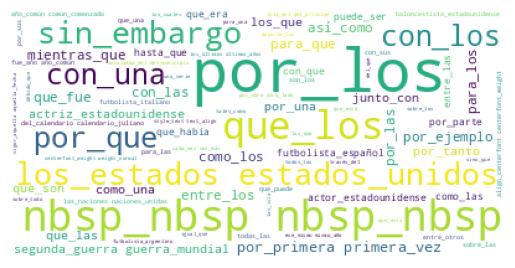

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

tgs = [f"{w1}_{w2}_{w3}".lower() for w1,w2,w3 in trigramas]
bgs = [f"{w1}_{w2}".lower() for w1,w2 in bigramas]

wc = WordCloud(background_color='white')
# wc.generate(" ".join(tgs))
wc.generate(" ".join(bgs))
plt.imshow(wc)
plt.axis('off')
plt.show()

## Generalizaciones de $n$-gramas

### Skipgrams

Un $k$-skip-$n$-gram es una subsecuencia de longitud $n$ en la que los tokens aparecen a una distancia $k$ como máximo entre sí.


https://www.nltk.org/api/nltk.util.html

In [ ]:
from nltk.util import skipgrams
from string import punctuation

punctuations = list(punctuation)

text = "The rain in Spain falls mainly on the plain"

tokenized_text = [t for t in nltk.word_tokenize(text) if t not in punctuations]

skip_grams = list(skipgrams(tokenized_text, 2, 1))
print(skip_grams)

[('The', 'rain'), ('The', 'in'), ('rain', 'in'), ('rain', 'Spain'), ('in', 'Spain'), ('in', 'falls'), ('Spain', 'falls'), ('Spain', 'mainly'), ('falls', 'mainly'), ('falls', 'on'), ('mainly', 'on'), ('mainly', 'the'), ('on', 'the'), ('on', 'plain'), ('the', 'plain')]
